In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rc('text', usetex = True)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


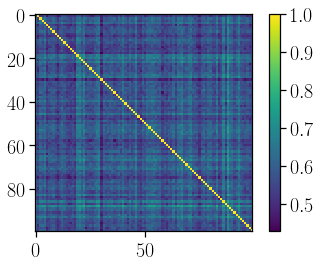

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


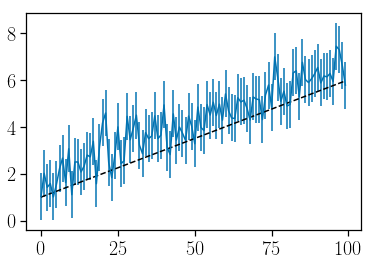

In [37]:
npts = 100

np.random.seed(24601)
A = np.random.rand(npts, npts)
Sigma = np.dot(A, A.T)
Sigma /= Sigma.max()
err = np.ones(npts)
np.fill_diagonal(Sigma, err**2)

# Sigma = np.diag(err**2)

plt.imshow(Sigma)
plt.colorbar()
plt.show()

x = np.arange(npts)
a, b = 0.05, 1.
trend = a*x + b
y = np.random.multivariate_normal(trend, Sigma)
plt.errorbar(range(npts), y, yerr=err)
plt.plot(x,trend,c='k', linestyle='--')
plt.show()

### Model without covariance

In [38]:
import pystan
overwrite=False
nocov = '''
data {
    int<lower = 0> N;
    vector[N] y;
    vector[N] x;
    vector[N] err;
}
parameters {
    real a;
    real b;
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    y ~ normal(a*x + b, err);
}
'''
import os
import pickle
model_path = 'nocov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = nocov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = nocov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [39]:
dat = {'N':len(y),
      'y' : y,
      'x' : x,
      'err' : err}
fit = sm.sampling(data=dat, iter=10000, chains=2)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


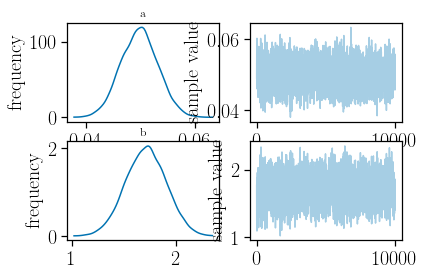

In [40]:
fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


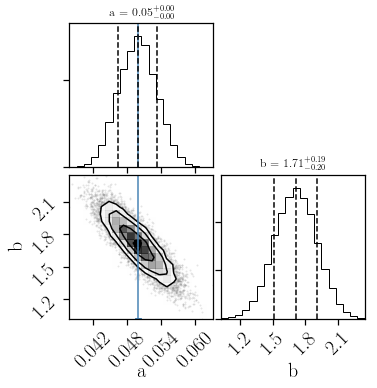

In [41]:
import corner
chains = np.array([fit['a'], fit['b']])
corner.corner(chains.T, labels=['a','b'], truths=[a, b],
              quantiles=[0.159, 0.50, 0.841],show_titles=True)
plt.show()
# plt.errorbar(range(npts), np.median(fit['ytrue'],axis=0),
#             yerr = np.std(fit['ytrue'],axis=0),fmt='o')
# plt.axhline(np.mean(means), c='k', linestyle='--')
# plt.ylabel('Y (True: 0.)')
# plt.xticks([])
# plt.show()

### With covariance matrix

In [42]:
import pystan
overwrite=True
cov_simple = '''
data {
    int<lower = 0> N;
    vector[N] y;
    vector[N] x;
    cov_matrix[N] Sigma;
}
parameters {
    real a;
    real b;
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    y ~ multi_normal(a*x + b, Sigma);
}
'''
import os
import pickle
model_path = 'cov_simple.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = cov_simple)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = cov_simple)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea3aa063ddefa2b352f308cb882b2464 NOW.


In [43]:
dat = {'N':len(y),
      'y' : y,
      'x': x,
      'Sigma' : Sigma}
fit_2 = sm.sampling(data=dat, iter=10000, chains=2)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


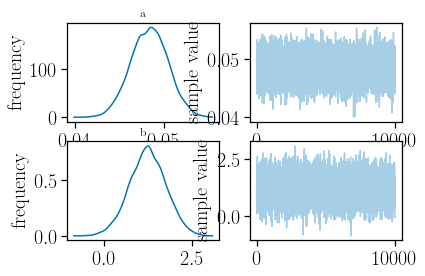

In [45]:
fit_2.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


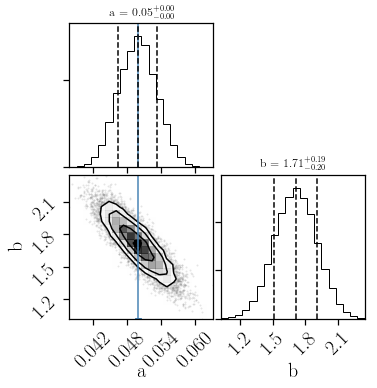

In [46]:
import corner
chains = np.array([fit['a'], fit['b']])
corner.corner(chains.T, labels=['a','b'], truths=[a, b],
              quantiles=[0.159, 0.50, 0.841],show_titles=True)
plt.show()
# plt.errorbar(range(npts), np.median(fit_2['ytrue'],axis=0),
#             yerr = np.std(fit_2['ytrue'],axis=0),fmt='o')
# plt.axhline(np.mean(means), c='k', linestyle='--')
# plt.ylabel('Y (True: 0.)')
# plt.xticks([])
# plt.grid()
# plt.show()

### With faster covariance matrix

In [11]:
import pystan
overwrite=False
cov_fast = '''
functions {
    real precalc_multinormal_lpdf(vector y, vector y_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = y - y_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real Nfloat;
    vector[N] y;
    matrix[N, N] invc;
    real logdetc;
}
parameters {
    vector[N] ytrue;
    real mu;
}
model {
    mu ~ normal(0., 1.);
    ytrue ~ normal(mu, 1.);
    y ~ precalc_multinormal(ytrue, logdetc, invc, N, Nfloat);
}
'''
import os
import pickle
model_path = 'cov_fast.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = cov_fast)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = cov_fast)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [12]:
dat = {'N':len(y),
       'Nfloat':np.float(len(y)),
      'y' : y,
      'invc': np.linalg.inv(Sigma),
      'logdetc':np.linalg.det(Sigma)}
fit_3 = sm.sampling(data=dat, iter=10000, chains=2)

0.4309318699693414


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


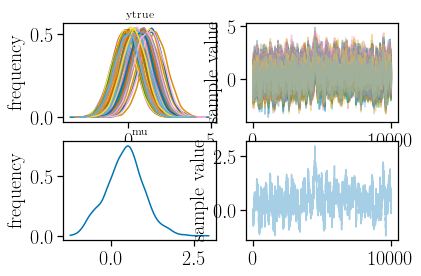

In [13]:
print(np.median(fit_3['ytrue']))
fit_3.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


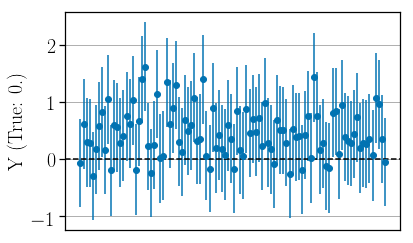

In [14]:
plt.errorbar(range(npts), np.median(fit_3['ytrue'],axis=0),
            yerr = np.std(fit_3['ytrue'],axis=0),fmt='o')
plt.axhline(np.mean(means), c='k', linestyle='--')
plt.ylabel('Y (True: 0.)')
plt.xticks([])
plt.grid()
plt.show()